# Deteccion de neumonia a partir de radiografia de torax

Instalacion de dependencias.

In [1]:
!pip3 install pandas
!pip3 install numpy
!pip3 install seaborn
!pip3 install glob2
!pip3 install matplotlib


[notice] A new release of pip available: 22.1.2 -> 22.2
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip available: 22.1.2 -> 22.2
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip available: 22.1.2 -> 22.2
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip available: 22.1.2 -> 22.2
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip available: 22.1.2 -> 22.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import glob
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import os
import random
import cv2
from sklearn import metrics
from sklearn.metrics import accuracy_score
from tensorflow.python.client import device_lib
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from sklearn.model_selection import train_test_split
from tensorflow.keras import callbacks
from sklearn.utils import class_weight

%matplotlib inline

# checkeamos que la gpu este configurada
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
device_lib.list_local_devices()

Num GPUs Available:  1


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 10087320051161651942
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 6943080448
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 2238634954963091561
 physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1070 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"
 xla_global_id: 416903419]

# Preparación de Datos

In [3]:
current_directory = os.getcwd()
path = current_directory + '/chest_xray'

In [4]:
IMG_SIZE = 160 
BATCH = 70

#random.seed(42)
os.environ['PYTHONHASHSEED'] = str(42)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

tf.random.set_seed(42)


SEED = 42
train_normal = glob.glob(current_directory + '/chest_xray/train_nuevo/normal/*')
train_pneumonia = glob.glob(current_directory + '/chest_xray/train_nuevo/pneumonia/*')

train_list = [x for x in train_normal]
train_list.extend([x for x in train_pneumonia])

test_normal = glob.glob(current_directory + '/chest_xray/test_nuevo/normal/*')
test_pneumonia = glob.glob(current_directory + '/chest_xray/test_nuevo/pneumonia/*')

train_list = [x for x in train_normal]
train_list.extend([x for x in train_pneumonia])

df_train = pd.DataFrame(np.concatenate([['Normal']*len(train_normal) , ['Pneumonia']*len(train_pneumonia)]), columns = ['class'])
df_train['image'] = [x for x in train_list]

test_list = [x for x in test_normal]
test_list.extend([x for x in test_pneumonia])

df_test = pd.DataFrame(np.concatenate([['Normal']*len(test_normal) , ['Pneumonia']*len(test_pneumonia)]), columns = ['class'])
df_test['image'] = [x for x in test_list]

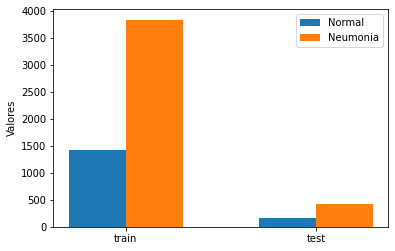

In [5]:
labels = ['train', 'test']
normal = [len(train_normal), len(test_normal) ]
pneumonia = [len(train_pneumonia), len(test_pneumonia)]

x = np.arange(len(labels))
width = 0.30  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, normal, width, label='Normal')
rects2 = ax.bar(x + width/2, pneumonia, width, label='Neumonia')

ax.set_ylabel('Valores')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.show()

Ejemplos Set de Entrenamiento - Normal


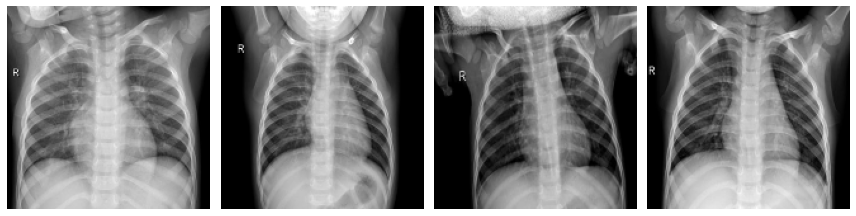

In [6]:
print('Ejemplos Set de Entrenamiento - Normal')

plt.figure(figsize=(12,12))

for i in range(0, 4):
    plt.subplot(3,4,i + 1)
    img = cv2.imread(train_normal[i])
    img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
    plt.imshow(img)
    plt.axis("off")

plt.tight_layout()

plt.show()

Ejemplos Set de Entrenamiento - Neumonia


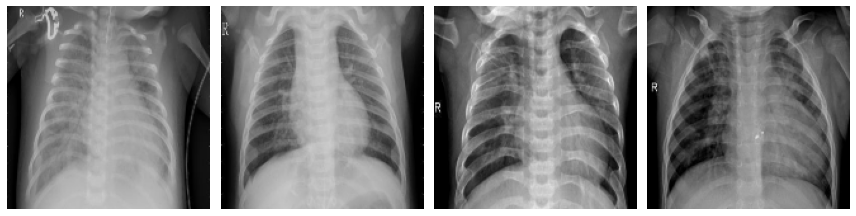

In [7]:
print('Ejemplos Set de Entrenamiento - Neumonia')

plt.figure(figsize=(12,12))

for i in range(0, 4):
    plt.subplot(3,4,i + 1)
    img = cv2.imread(train_pneumonia[i])
    img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
    plt.imshow(img)
    plt.axis("off")

plt.tight_layout()

plt.show()

In [8]:
train_df, val_df = train_test_split(df_train, test_size = 0.20, random_state = SEED, stratify = df_train['class'])

# Data Augmentation

In [9]:
train_datagen = ImageDataGenerator(rescale=1/255.,
                                  zoom_range = 0.1,
                                  #rotation_range = 0.1,
                                  width_shift_range = 0.1,
                                  height_shift_range = 0.1)

val_datagen = ImageDataGenerator(rescale=1/255.)

ds_train = train_datagen.flow_from_dataframe(train_df,
                                             x_col = 'image',
                                             y_col = 'class',
                                             target_size = (IMG_SIZE, IMG_SIZE),
                                             class_mode = 'binary',
                                             batch_size = BATCH,
                                             seed = SEED)

ds_val = val_datagen.flow_from_dataframe(val_df,
                                            x_col = 'image',
                                            y_col = 'class',
                                            target_size = (IMG_SIZE, IMG_SIZE),
                                            class_mode = 'binary',
                                            batch_size = BATCH,
                                            seed = SEED)

ds_test = val_datagen.flow_from_dataframe(df_test,
                                            x_col = 'image',
                                            y_col = 'class',
                                            target_size = (IMG_SIZE, IMG_SIZE),
                                            class_mode = 'binary',
                                            batch_size = 1,
                                            shuffle = False)
                                            

early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    min_delta=1e-7,
    restore_best_weights=True,
)

plateau = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor = 0.2,                                     
    patience = 2,                                   
    min_delt = 1e-7,                                
    cooldown = 0,                               
    verbose = 1
) 

class_weights = class_weight.compute_class_weight(
           class_weight='balanced',
            classes = np.unique(ds_train.classes), 
            y= ds_train.classes)

train_class_weights = dict(enumerate(class_weights))

Found 4211 validated image filenames belonging to 2 classes.
Found 1053 validated image filenames belonging to 2 classes.
Found 592 validated image filenames belonging to 2 classes.


# ResNet15V2

In [78]:
base_model = tf.keras.applications.ResNet152V2(
    weights='imagenet',
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False)

base_model.trainable = False

def get_pretrained():
    
    
    inputs = tf.keras.layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    
    x = base_model(inputs)

    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.1)(x)
    
    
    output = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    model = tf.keras.Model(inputs=[inputs], outputs=output)
    
    return model

tf.keras.backend.clear_session()

model_pretrained = get_pretrained()
model_pretrained.compile(loss='binary_crossentropy'
              , optimizer = tf.keras.optimizers.Adam(), metrics=['binary_accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])

model_pretrained.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 resnet152v2 (Functional)    (None, 5, 5, 2048)        58331648  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                             

In [79]:
history = model_pretrained.fit(ds_train,
          batch_size = BATCH, epochs = 70,
          validation_data=ds_val,
          callbacks=[early_stopping, plateau],
          steps_per_epoch=(len(train_df)/BATCH),
          validation_steps=(len(val_df)/BATCH));

Epoch 1/70
60/60 [==============================] - 53s 741ms/step - loss: 0.2971 - binary_accuracy: 0.8886 - precision: 0.9186 - recall: 0.9297 - val_loss: 0.1675 - val_binary_accuracy: 0.9392 - val_precision: 0.9607 - val_recall: 0.9557 - lr: 0.0010
Epoch 2/70
60/60 [==============================] - 40s 661ms/step - loss: 0.1805 - binary_accuracy: 0.9278 - precision: 0.9482 - recall: 0.9531 - val_loss: 0.1653 - val_binary_accuracy: 0.9392 - val_precision: 0.9681 - val_recall: 0.9479 - lr: 0.0010
Epoch 3/70
60/60 [==============================] - 39s 656ms/step - loss: 0.1672 - binary_accuracy: 0.9347 - precision: 0.9519 - recall: 0.9590 - val_loss: 0.1472 - val_binary_accuracy: 0.9487 - val_precision: 0.9685 - val_recall: 0.9609 - lr: 0.0010
Epoch 4/70
60/60 [==============================] - 39s 652ms/step - loss: 0.1513 - binary_accuracy: 0.9413 - precision: 0.9585 - recall: 0.9613 - val_loss: 0.1375 - val_binary_accuracy: 0.9516 - val_precision: 0.9711 - val_recall: 0.9622 - lr:

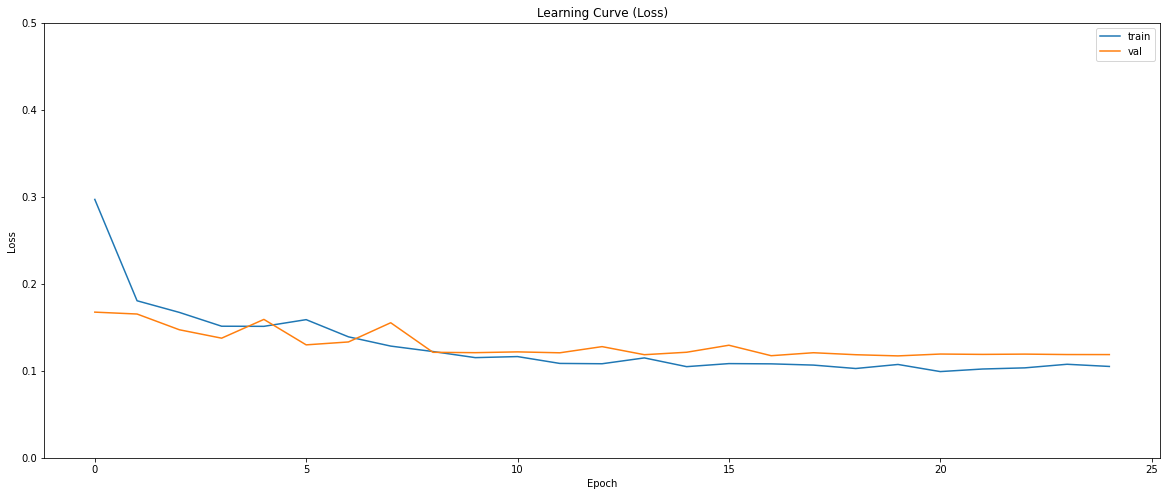

In [80]:
fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x = history.epoch, y = history.history['loss'])
sns.lineplot(x = history.epoch, y = history.history['val_loss'])
ax.set_title('Learning Curve (Loss)')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.set_ylim(0, 0.5)
ax.legend(['train', 'val'], loc='best')
plt.show()

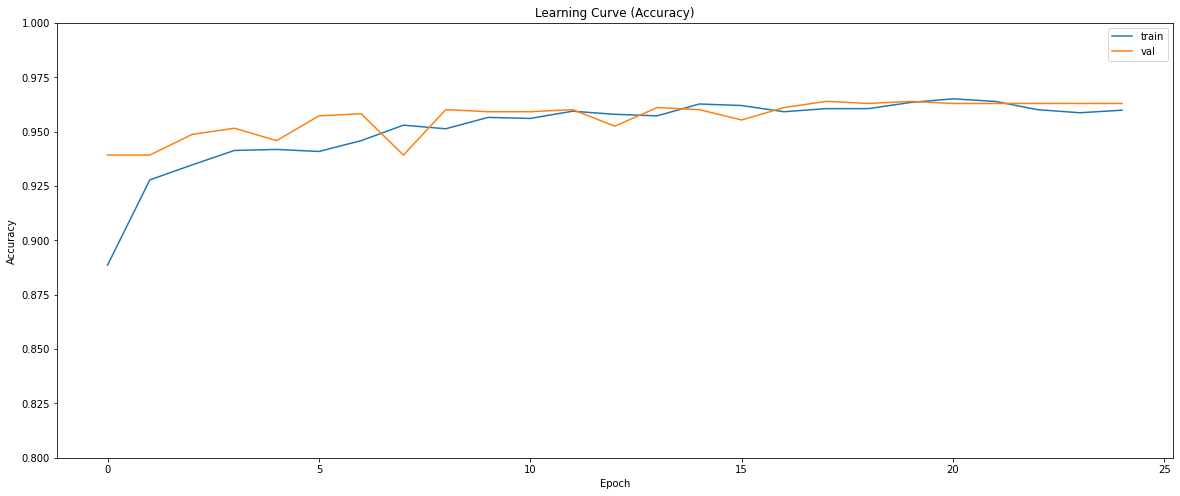

In [81]:
fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x = history.epoch, y = history.history['binary_accuracy'])
sns.lineplot(x = history.epoch, y = history.history['val_binary_accuracy'])
ax.set_title('Learning Curve (Accuracy)')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epoch')
ax.set_ylim(0.80, 1.0)
ax.legend(['train', 'val'], loc='best')
plt.show()

In [82]:
score = model_pretrained.evaluate(ds_val, steps = len(val_df)/BATCH, verbose = 0)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

Val loss: 0.1171657145023346
Val accuracy: 0.9639126062393188


In [83]:
score = model_pretrained.evaluate(ds_test, steps = len(df_test), verbose = 0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.1094980463385582
Test accuracy: 0.9645270109176636


In [84]:
num_label = {'Normal': 0, 'Pneumonia' : 1}
Y_test = df_test['class'].copy().map(num_label).astype('int')

ds_test.reset()
predictions = model_pretrained.predict(ds_test, steps=len(ds_test), verbose=0)
pred_labels= np.where(predictions>0.5, 1, 0)

print("Test Accuracy: ", accuracy_score(Y_test, pred_labels))

Test Accuracy:  0.964527027027027


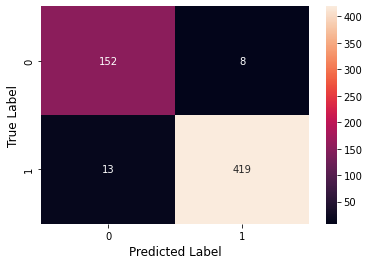

In [85]:
confusion_matrix = metrics.confusion_matrix(Y_test, pred_labels)
sns.heatmap(confusion_matrix, annot=True, fmt="d")

plt.xlabel("Predicted Label", fontsize= 12)
plt.ylabel("True Label", fontsize= 12)

plt.show()

In [87]:
print(metrics.classification_report(Y_test, pred_labels, labels = [0,1]))

              precision    recall  f1-score   support

           0       0.92      0.95      0.94       160
           1       0.98      0.97      0.98       432

    accuracy                           0.96       592
   macro avg       0.95      0.96      0.96       592
weighted avg       0.97      0.96      0.96       592



# VGG19

In [10]:
base_model = tf.keras.applications.VGG19(
    weights='imagenet',
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False)

base_model.trainable = False

def get_pretrained():
    
    
    inputs = tf.keras.layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    
    x = base_model(inputs)

    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.1)(x)
    
    
    output = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    model = tf.keras.Model(inputs=[inputs], outputs=output)
    
    return model

tf.keras.backend.clear_session()

model_pretrained = get_pretrained()
model_pretrained.compile(loss='binary_crossentropy'
             , optimizer = tf.keras.optimizers.Adam(), metrics=['binary_accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])

model_pretrained.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 vgg19 (Functional)          (None, 5, 5, 512)         20024384  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               65664     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                             

In [11]:
history = model_pretrained.fit(ds_train,
          batch_size = BATCH, epochs = 70,
          validation_data=ds_val,
          callbacks=[early_stopping, plateau],
          steps_per_epoch=(len(train_df)/BATCH),
          validation_steps=(len(val_df)/BATCH));

Epoch 1/70
60/60 [==============================] - 52s 758ms/step - loss: 0.4125 - binary_accuracy: 0.8093 - precision: 0.8144 - recall: 0.9567 - val_loss: 0.3066 - val_binary_accuracy: 0.8718 - val_precision: 0.8971 - val_recall: 0.9310 - lr: 0.0010
Epoch 2/70
60/60 [==============================] - 42s 696ms/step - loss: 0.2943 - binary_accuracy: 0.8739 - precision: 0.8972 - recall: 0.9343 - val_loss: 0.2668 - val_binary_accuracy: 0.8832 - val_precision: 0.9119 - val_recall: 0.9297 - lr: 0.0010
Epoch 3/70
60/60 [==============================] - 42s 706ms/step - loss: 0.2680 - binary_accuracy: 0.8839 - precision: 0.9096 - recall: 0.9336 - val_loss: 0.2648 - val_binary_accuracy: 0.8841 - val_precision: 0.9449 - val_recall: 0.8932 - lr: 0.0010
Epoch 4/70
60/60 [==============================] - 42s 698ms/step - loss: 0.2446 - binary_accuracy: 0.9003 - precision: 0.9231 - recall: 0.9418 - val_loss: 0.3114 - val_binary_accuracy: 0.8594 - val_precision: 0.9613 - val_recall: 0.8411 - lr:

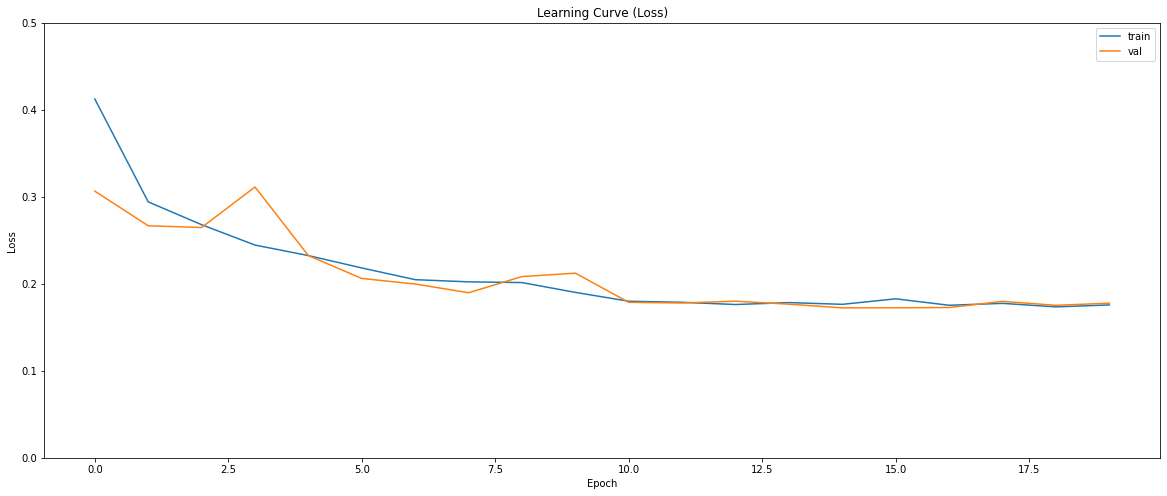

In [12]:
fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x = history.epoch, y = history.history['loss'])
sns.lineplot(x = history.epoch, y = history.history['val_loss'])
ax.set_title('Learning Curve (Loss)')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.set_ylim(0, 0.5)
ax.legend(['train', 'val'], loc='best')
plt.show()

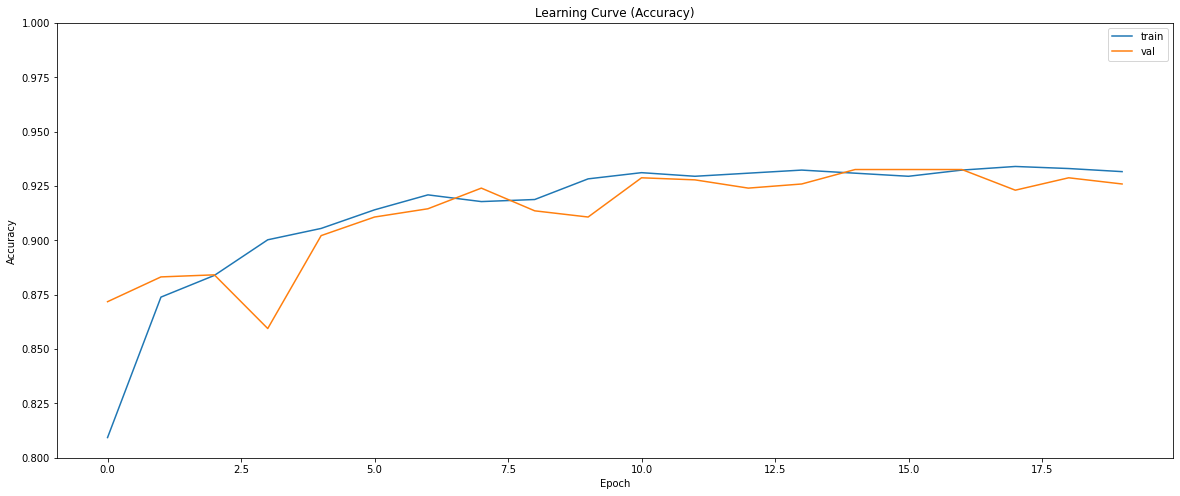

In [13]:
fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x = history.epoch, y = history.history['binary_accuracy'])
sns.lineplot(x = history.epoch, y = history.history['val_binary_accuracy'])
ax.set_title('Learning Curve (Accuracy)')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epoch')
ax.set_ylim(0.80, 1.0)
ax.legend(['train', 'val'], loc='best')
plt.show()

In [14]:
score = model_pretrained.evaluate(ds_val, steps = len(val_df)/BATCH, verbose = 0)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

Val loss: 0.1723957508802414
Val accuracy: 0.9325736165046692


In [15]:
score = model_pretrained.evaluate(ds_test, steps = len(df_test), verbose = 0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.15205702185630798
Test accuracy: 0.9442567825317383


In [16]:
num_label = {'Normal': 0, 'Pneumonia' : 1}
Y_test = df_test['class'].copy().map(num_label).astype('int')

ds_test.reset()
predictions = model_pretrained.predict(ds_test, steps=len(ds_test), verbose=0)
pred_labels= np.where(predictions>0.5, 1, 0)

print("Test Accuracy: ", accuracy_score(Y_test, pred_labels))

Test Accuracy:  0.9442567567567568


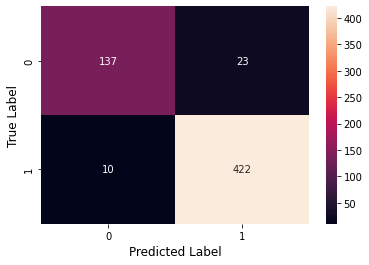

In [19]:
confusion_matrix = metrics.confusion_matrix(Y_test, pred_labels)
sns.heatmap(confusion_matrix, annot=True, fmt="d")

plt.xlabel("Predicted Label", fontsize= 12)
plt.ylabel("True Label", fontsize= 12)

plt.show()

In [20]:
print(metrics.classification_report(Y_test, pred_labels, labels = [0,1]))

              precision    recall  f1-score   support

           0       0.93      0.86      0.89       160
           1       0.95      0.98      0.96       432

    accuracy                           0.94       592
   macro avg       0.94      0.92      0.93       592
weighted avg       0.94      0.94      0.94       592



# Modelo Propio

In [97]:
from tensorflow.keras.layers import Input, Dense, Conv2D, Flatten, MaxPooling2D, Dropout,GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model

inputs = tf.keras.layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

d = Conv2D(32, (3, 3),activation='relu')(inputs)
d = Conv2D(32, (3, 3),activation='relu')(d)                                                                                                                                     #(x,y):dim filtro, c:#colores, b:matriz bias, f:#filtros
d = MaxPooling2D(pool_size=(2,2))(d)
d = Conv2D(64, (3,3),activation='relu')(d)
d = Conv2D(64, (3,3),activation='relu')(d)
d = MaxPooling2D(pool_size=(2,2))(d)
d = Conv2D(128, (3,3),activation='relu')(d)
d = Conv2D(128, (3,3),activation='relu')(d)
d = BatchNormalization()(d)
d = MaxPooling2D(pool_size=(2,2))(d)
d = Conv2D(256, (3,3),activation='relu')(d)
d = BatchNormalization()(d)
d = Conv2D(256, (3,3),activation='relu')(d)
d = BatchNormalization()(d)
d = MaxPooling2D(pool_size=(2,2))(d)
d = Conv2D(512, (3,3),activation='relu')(d)
d = BatchNormalization()(d)
d = Conv2D(512, (3,3),activation='relu')(d)
d = BatchNormalization()(d)
d = Flatten()(d)
d = Dense(2048, activation='relu')(d)
d = Dense(1024, activation='relu')(d)
d = Dense(512, activation='relu')(d)
o = Dense(1, activation='sigmoid')(d)



model=Model(inputs=[inputs], outputs=o)

model.compile(loss='binary_crossentropy'
              , optimizer = tf.keras.optimizers.Adam(), metrics=['binary_accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 158, 158, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 156, 156, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 78, 78, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 76, 76, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 74, 74, 64)        36928     
                                                           

In [106]:
history = model.fit(ds_train,
          batch_size = BATCH, epochs = 70,
          validation_data=ds_val,
          callbacks=[early_stopping, plateau],
          steps_per_epoch=(len(train_df)/BATCH),
          validation_steps=(len(val_df)/BATCH));

Epoch 1/70
60/60 [==============================] - 32s 530ms/step - loss: 0.1530 - binary_accuracy: 0.9430 - precision_1: 0.9559 - recall_1: 0.9665 - val_loss: 0.2119 - val_binary_accuracy: 0.9231 - val_precision_1: 0.9084 - val_recall_1: 0.9948 - lr: 4.0000e-05
Epoch 2/70
60/60 [==============================] - 32s 528ms/step - loss: 0.1335 - binary_accuracy: 0.9506 - precision_1: 0.9617 - recall_1: 0.9710 - val_loss: 0.1211 - val_binary_accuracy: 0.9563 - val_precision_1: 0.9593 - val_recall_1: 0.9818 - lr: 4.0000e-05
Epoch 3/70
60/60 [==============================] - 32s 527ms/step - loss: 0.1352 - binary_accuracy: 0.9463 - precision_1: 0.9620 - recall_1: 0.9645 - val_loss: 0.1136 - val_binary_accuracy: 0.9582 - val_precision_1: 0.9629 - val_recall_1: 0.9805 - lr: 4.0000e-05
Epoch 4/70
60/60 [==============================] - 32s 530ms/step - loss: 0.1310 - binary_accuracy: 0.9508 - precision_1: 0.9617 - recall_1: 0.9714 - val_loss: 0.1103 - val_binary_accuracy: 0.9611 - val_prec

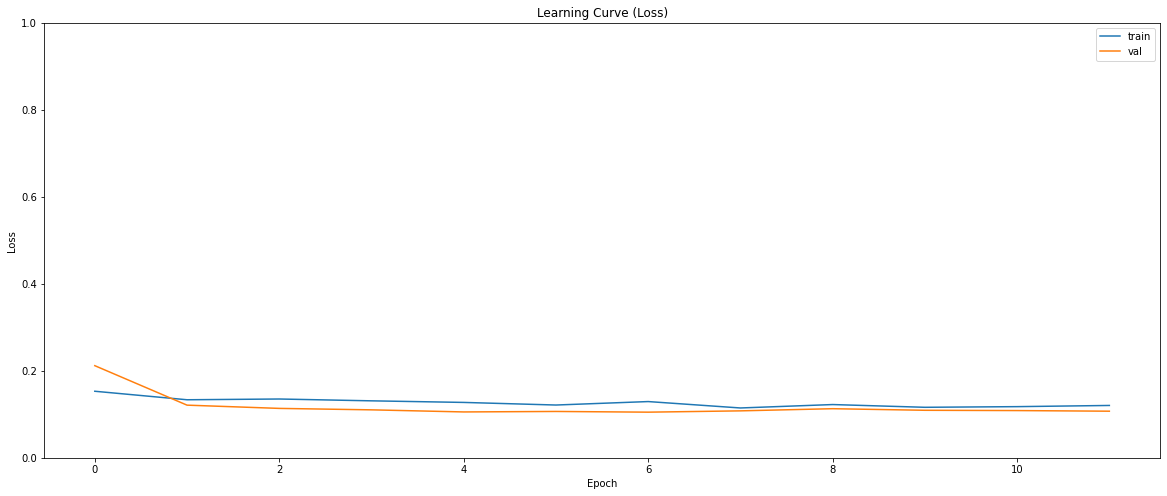

In [107]:
fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x = history.epoch, y = history.history['loss'])
sns.lineplot(x = history.epoch, y = history.history['val_loss'])
ax.set_title('Learning Curve (Loss)')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.set_ylim(0,1)
ax.legend(['train', 'val'], loc='best')
plt.show()

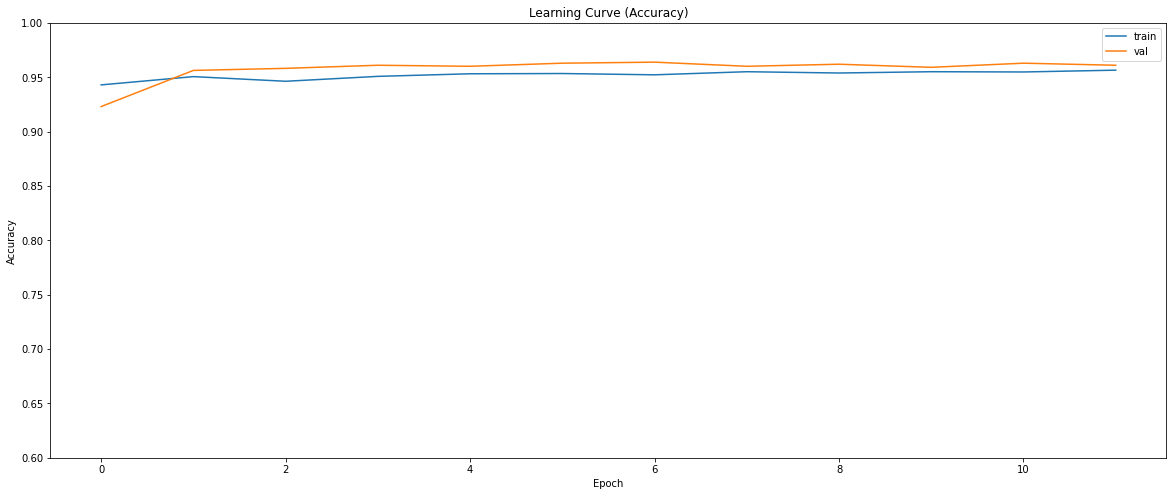

In [108]:
fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x = history.epoch, y = history.history['binary_accuracy'])
sns.lineplot(x = history.epoch, y = history.history['val_binary_accuracy'])
ax.set_title('Learning Curve (Accuracy)')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epoch')
ax.set_ylim(0.60, 1.0)
ax.legend(['train', 'val'], loc='best')
plt.show()

In [109]:
score = model.evaluate(ds_val, steps = len(val_df)/BATCH, verbose = 0)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

Val loss: 0.10493695735931396
Val accuracy: 0.9639126062393188


In [110]:
score = model.evaluate(ds_test, steps = len(df_test), verbose = 0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.12483921647071838
Test accuracy: 0.9527027010917664


In [111]:
num_label = {'Normal': 0, 'Pneumonia' : 1}
Y_test = df_test['class'].copy().map(num_label).astype('int')

ds_test.reset()
predictions = model.predict(ds_test, steps=len(ds_test), verbose=0)
pred_labels= np.where(predictions>0.5, 1, 0)

print("Test Accuracy: ", accuracy_score(Y_test, pred_labels))

Test Accuracy:  0.9527027027027027


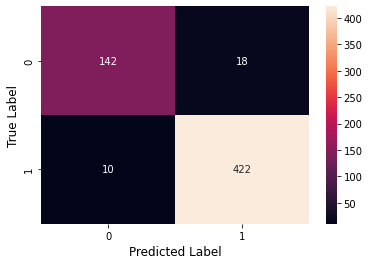

In [112]:
confusion_matrix = metrics.confusion_matrix(Y_test, pred_labels)
sns.heatmap(confusion_matrix, annot=True, fmt="d")

plt.xlabel("Predicted Label", fontsize= 12)
plt.ylabel("True Label", fontsize= 12)

plt.show()

In [113]:
print(metrics.classification_report(Y_test, pred_labels, labels = [0,1]))

              precision    recall  f1-score   support

           0       0.93      0.89      0.91       160
           1       0.96      0.98      0.97       432

    accuracy                           0.95       592
   macro avg       0.95      0.93      0.94       592
weighted avg       0.95      0.95      0.95       592

